**Batch Detect Puncta v1.4**

Aim: Detect puncta for a whole field of view!!

- added stdev and median calculation from region props (excludes 0=value pixels)
- tidied up since v1.2
- added seaborn

In [1]:
import pandas as pd
import time
import skimage.io as io
io.use_plugin('tifffile')
import glob
from skimage import morphology
import mahotas as mh
from skimage.filters import threshold_adaptive
from scipy.ndimage import distance_transform_edt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import regionprops

**Define Functions**

In [2]:
#load Hoechst and GFP stacks from .ome.tif files
def load_ome(ome_stack_file):

    #MMStack .ome.tif files load channel,z,y,x
    #Check file contains .ome.tif
    if '.ome.tif' in ome_stack_file:

        #Load the file
        im=io.imread(ome_stack_file)

        #Select Hoechst stack
        Hoechst_stack = im[0,:,:,:] #Hoechst Channel = 0
        GFP_stack = im[1,:,:,:]     #GFP Channel = 1
        
        #
        return [Hoechst_stack, GFP_stack]
        #return GFP_stack
        
    else:
        print 'this is not an ome.tif'

In [3]:
#Generate crop coordinates from the pandas data frame for a given index
def crop_crds(hull_index):

    #Use 'icol' to query pd.df 'Hull_Properties' with an integer
    Hull=Hull_Properties.iloc[hull_index]

    #Calculate cropped image coordinates
    z = int(Hull[2])
    y_min = int(Hull[1]-256)
    y_max = int(Hull[1]+256)
    x_min = int(Hull[0]-256)
    x_max = int(Hull[0]+256)
    
    return (z, y_min, y_max, x_min, x_max)

In [4]:
#from skimage.filters import threshold_adaptive
#block_size and offset are optional arguments, with default parameters 35 and -20 respectively   
#block_size = Width of neighbourhood in pixels. Default was 35. I have set it to 9 for KDM5A puncta (even detects the hollow donuts)
#offset = Constant subtracted from mean. Default was 10. I have set it to -40 for GFP

#local threshold each frame in the stack
def localThreshStack(stack, block_size = 9, offset = -40):

    #Must be a 2D array
    if len(stack.shape)>2:
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            #print(z)
            mask[z] = threshold_adaptive(frame, block_size, 'mean', offset)
        return mask     
    else:
        print 'Input is not a 3D stack'
        return threshold_adaptive(stack, block_size, 'mean', offset)

In [5]:
def getHullProperties(intensity_image, label_image):
    
    props=[]
    heading=["Hull", "Center_x", "Center_y", "Center_z", "volume",  "integrated_GFP", "mean_GFP", "std_GFP", "median_GFP", "threshold_GFP"]

    #Measure hull properties
    hull_props=regionprops(label_image, intensity_image)

    for h in hull_props:

        #Get bounding box
        bb=np.array(h.bbox)
        #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox

        #Calculate Center
        zcent=int(round((bb[0]+bb[3])/2))
        ycent=int(round((bb[1]+bb[4])/2))
        xcent=int(round((bb[2]+bb[5])/2))

        #Calculate stdev and median
        mask = h.intensity_image != 0

        std = np.std(h.intensity_image[mask])
        median = np.median(h.intensity_image[mask])

        #Calculate threshold
        thresh=median+(1.5*std)

        props.append([int(h.label),
                      xcent,
                      ycent,
                      zcent,
                      h.area,
                      h.mean_intensity * h.area,
                      h.mean_intensity,
                      std,
                      median,
                      thresh])

    return pd.DataFrame(props, columns=heading)

Rename variables to make detectPuncta generic

In [6]:
def detectPuncta(GFP_stack, hulls):
       
    #Find Puncta by adaptive thresholding
    GFP_mask3 = localThreshStack(GFP_stack)
    
    ##Intersect GFP mask with convex hulls to get GFP_mask5
    GFP_mask5 = GFP_mask3 * (hulls>0)

    ##Calculate 3D distance transform (slow)
    #from scipy.ndimage import distance_transform_edt
    blob_dis = distance_transform_edt(GFP_mask5)

    #Limit to >1 to isolate blobs
    iso_blobs = blob_dis>1

    #Label GFP regions (quick)
    GFP_blobs, n_blobs = mh.label(iso_blobs)
    
    #Filter by size
    #from mahotas.labeled import filter_labeled
    filt_blobs, _ = mh.labeled.filter_labeled(GFP_blobs, min_size=27)              #Variable min_size

    #Reset counts and count the labels, 
    real_blobs, n_blobs_left = mh.labeled.relabel(filt_blobs)
    
    #Return labeled puncta 'real_blobs'
    return real_blobs
    #return [n_blobs, n_blobs_left, real_blobs]    

In [7]:
def getPunctaProperties(intensity_image, label_image):

    #Get puncta properties
    props=[]
    heading=["Puncta", "Center_x", "Center_y", "Center_z", "volume", "mean_GFP", "integrated_GFP"]

    punc_props = regionprops(label_image, intensity_image)

    for p in punc_props:

        #Get bounding box
        bb=np.array(p.bbox)
        #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox

        #Calculate Center
        zcent=int(round((bb[0]+bb[3])/2))
        ycent=int(round((bb[1]+bb[4])/2))
        xcent=int(round((bb[2]+bb[5])/2))

        props.append([int(p.label),
                      xcent,
                      ycent,
                      zcent,
                      p.area,
                      p.mean_intensity,
                      p.mean_intensity * p.area])
    
    return pd.DataFrame(props, columns=heading)

In [8]:
##Find out which hull each puncta belongs to.
def assignPuncta(puncta_image, hull_image):

    loc=[]
    #Get puncta properties, by using labeled hull as the intensity image 
    punc_loc=regionprops(label_image=puncta_image, intensity_image=hull_image)

    for p in punc_loc:        
        loc.append(int(p.mean_intensity))
    return loc

In [9]:
##Define a generic puncta/Hull function
def PunctaByHull(Puncta_Properties_Column_Name, Hull_Properties_Column_Name):
    return np.divide(np.array(Puncta_Properties[Puncta_Properties_Column_Name].astype(float)),np.array(Hull_Properties.loc[Puncta_Properties["Hull"],Hull_Properties_Column_Name].astype(float)))

**Set input and output directories**

In [137]:
#[2] Get targeted filelist
path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

In [138]:
#[3] Get convex hull list
hull_list=glob.glob(path+str('/Output/ConvexHulls/*ConvHulls.npy'))

In [139]:
#[4] Specify output directory
output='Puncta/'
newpath = path+output
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [140]:
filelist

['C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well02_HeLa_PHD2-IDR-PHD3_1_MMStack_Pos0.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well02_HeLa_PHD2-IDR-PHD3_2_MMStack_Pos0.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well02_HeLa_PHD2-IDR-PHD3_3_MMStack_Pos0.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well03_HeLa_PHD2-IDR-PHD3[W1625A]_1_MMStack_Pos0.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well03_HeLa_PHD2-IDR-PHD3[W1625A]_3_MMStack_Pos0.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well03_HeLa_PHD2-IDR-PHD3[W1625A]_4_MMStack_Pos0.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well04_HeLa_PHD2-IDR_1_MMStack_Pos0.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well04_HeLa_PHD2-IDR_2_MMStack_Pos0.ome.

In [ ]:
##It should go Experiment>Well>Stack>Hull>Puncta

**Iterate through files**

-need to extract well and replicate number info, to store in a global table.


In [141]:
#[5] Iterate through a filelist an concatenate data

All_Hulls=pd.DataFrame()
All_Spots=pd.DataFrame()

for ff in range(len(filelist)):
    filepath=filelist[ff]
    filename = os.path.basename(filepath)
    
    #Remove microscope suffix
    stackname = filename.replace('_MMStack_Pos0.ome.tif', '')
    print(stackname)
    
    #Extract well number
    lowname=stackname.lower()
    well = stackname[lowname.index('well'):lowname.index('well')+6]
    
    #Extract stack number
    #stack = anything after the last '_'
    #use reverse find 'rfind' 
    stack = stackname[stackname.rfind("_")+1:]
        
    #Generate filename for Labeled Puncta
    Punctafilename = filename.replace('_MMStack_Pos0.ome.tif', '_Puncta')

    #Generate path for Labeled Puncta
    PunctaPath = newpath+Punctafilename
    
    #Identify the cognate convexhull mask
    matching = [s for s in hull_list if stackname in s]
    
    if (len(matching) != 1):
        print "There is no unique hull file for this input image"
    else:
        hullpath = matching[0]
        hullname = os.path.basename(hullpath)
        print(hullname) 
        
        #Extract channel information for a given file
        [Hoechst_stack, GFP_stack] = load_ome(filepath)
    
        #Load hulls
        hulls = np.load(hullpath)
        
        #Measure and collect Hull_Properties
        Hull_Properties = getHullProperties(GFP_stack, hulls)
        
        #Pass the current Well and Stack ID adding to the lefthand side
        Hull_Properties.insert(0, "Stack", int(stack))
        Hull_Properties.insert(0, "Well", well)
        
        #Save Hull Properties in the output directory
        HullPath=PunctaPath.replace("_Puncta","_Hull")
        Hull_Properties.to_csv(HullPath+"_Properties.csv")
        
        #Add Hull_Properties for the current file to the list
        All_Hulls=All_Hulls.append(Hull_Properties)
               
        #Detect and label puncta from the intensity image within the convex hulls
        real_blobs = detectPuncta(GFP_stack, hulls)
        
        ##Save puncta
        np.save(PunctaPath, real_blobs)
                
        #Measure and collect Puncta_Properties
        Puncta_Properties = getPunctaProperties(GFP_stack, real_blobs)
        
        #Assign each puncta to its cognate hull
        Puncta_Properties.insert(0, "Hull", int(assignPuncta(real_blobs, hulls)))
        
        #Pass the current Well and Stack ID adding to the lefthand side
        Puncta_Properties.insert(0, "Stack", int(stack))
        Puncta_Properties.insert(0, "Well", well)
              
        #Save Puncta_Properties in the output directory
        Puncta_Properties.to_csv(PunctaPath+"_Properties.csv")
        
        #Add Puncta_Properties for the current file to the list
        All_Spots=All_Spots.append(Puncta_Properties)
        
print "Processed"        

Well02_HeLa_PHD2-IDR-PHD3_1
Well02_HeLa_PHD2-IDR-PHD3_1_ConvHulls.npy
Well02_HeLa_PHD2-IDR-PHD3_2
Well02_HeLa_PHD2-IDR-PHD3_2_ConvHulls.npy
Well02_HeLa_PHD2-IDR-PHD3_3
Well02_HeLa_PHD2-IDR-PHD3_3_ConvHulls.npy
Well03_HeLa_PHD2-IDR-PHD3[W1625A]_1
Well03_HeLa_PHD2-IDR-PHD3[W1625A]_1_ConvHulls.npy
Well03_HeLa_PHD2-IDR-PHD3[W1625A]_3
Well03_HeLa_PHD2-IDR-PHD3[W1625A]_3_ConvHulls.npy
Well03_HeLa_PHD2-IDR-PHD3[W1625A]_4
Well03_HeLa_PHD2-IDR-PHD3[W1625A]_4_ConvHulls.npy
Well04_HeLa_PHD2-IDR_1
Well04_HeLa_PHD2-IDR_1_ConvHulls.npy
Well04_HeLa_PHD2-IDR_2
Well04_HeLa_PHD2-IDR_2_ConvHulls.npy
Well04_HeLa_PHD2-IDR_3
Well04_HeLa_PHD2-IDR_3_ConvHulls.npy
Processed


**Congratulations!!**

You have done the heavy lifting.

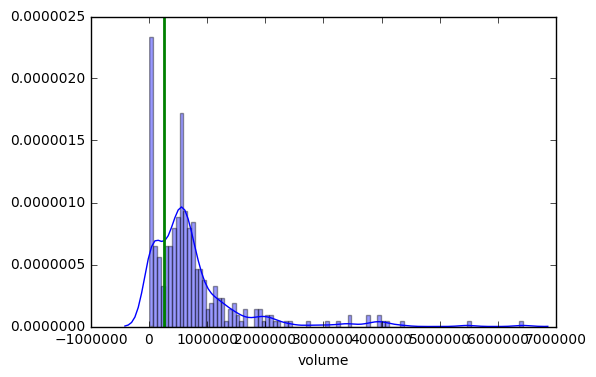

In [259]:
sns.distplot(All_Hulls['volume'], bins=100)
plt.plot([250000, 250000], [0, 0.0000025], linewidth=2)

[A] Calculate puncta properties for each nucleus

In [211]:
#Count Puncta in each nuceli
aggs = All_Spots.groupby(['Well', 'Stack', 'Hull'])['Puncta'].count()

In [340]:
##Can we add more data during the aggregation phase?
aggy2 = {'mean_GFP' : {'n_Puncta' : 'count',
                        'mean_Puncta_GFP': 'mean',
                          'std_Puncta_GFP' : 'std'
                      },
        'volume': {'mean_Puncta_volume': 'mean',
                  'std_Puncta_volume': 'std'}
        }

aggs2 = All_Spots.groupby(['Well', 'Stack', 'Hull']).agg(aggy2)

##Rename the columns to simplify referencing after merge
aggs2.columns=['std_Puncta_volume','mean_Puncta_volume','mean_Puncta_GFP','n_Puncta','std_Puncta_GFP']

#Reorder the columns
aggs2=aggs2[[3,2,4,1,0]]
aggs2

n_Puncta  mean_Puncta_GFP  std_Puncta_GFP  \
Well   Stack Hull                                              
Well02 1     26.0         1       616.294118             NaN   
       2     7.0        444      2917.083396      539.553376   
             12.0         1       703.275000             NaN   
             17.0       345      2163.854803      308.172023   
             24.0         4       728.196725       93.217281   
Well03 1     14.0        16       796.977984       51.631764   
             16.0         3       644.166398       14.504523   
             18.0        28       974.137476       90.250426   
       3     10.0        11       895.818004       79.766637   
             12.0        85      1374.881575      408.514938   
             20.0        22       790.542048       83.533905   
             23.0       164      1826.896428      920.739064   
Well04 1     28.0       142      1805.655575      711.697333   
             37.0       180      3667.913455     1292.728955   
             38.0       194      3240.385962     1125.078639   
       2     12.0        50      1003.441197      179.785655   
             31.0        82      1513.754209      660.494827   
             32.0       107      2197.210963      681.370492   
             44.0        48      1203.618379      298.610957   
       3     5.0         29      1094.545082      262.100566   

                   mean_Puncta_volume  std_Puncta_volume  
Well   Stack Hull                                         
Well02 1     26.0           34.000000                NaN  
       2     7.0           174.966216         378.074427  
             12.0           40.000000                NaN  
             17.0          149.828986         315.013025  
             24.0           31.000000           1.414214  
Well03 1     14.0           52.000000          23.105555  
             16.0           55.000000           7.000000  
             18.0           67.535714          40.793502  
       3     10.0           85.363636          60.399127  
             12.0          120.588235         172.452843  
             20.0           92.272727          69.521618  
             23.0          141.347561         246.398241  
Well04 1     28.0           89.204225         112.240910  
             37.0          160.427778         126.841653  
             38.0          204.417526         322.675531  
       2     12.0           78.580000          60.018395  
             31.0           80.439024          84.896029  
             32.0          148.990654         200.396423  
             44.0           89.458333          74.845645  
       3     5.0           100.172414         103.155593

In [336]:
##Save All_Hulls
All_Hulls.to_csv(newpath+"_All_Hulls.csv")

In [ ]:
#Convert Well, Stack and Hull info to a multilevel index
#All_Hulls.set_index(['Well', 'Stack', 'Hull'], drop=True, inplace=True)

In [ ]:
##Add aggregate data to the All_Hulls dataframe
All_Hulls2=pd.concat([All_Hulls, aggs2], axis=1)

In [342]:
#Replace NaN values with 0
All_Hulls2['n_Puncta'].fillna(value=0, inplace=True)

In [343]:
All_Hulls2['Punctate'] = All_Hulls2['n_Puncta']>0

In [344]:
#To colour plots by MultiLevel index, use .reset_index()
df2=All_Hulls2.reset_index()

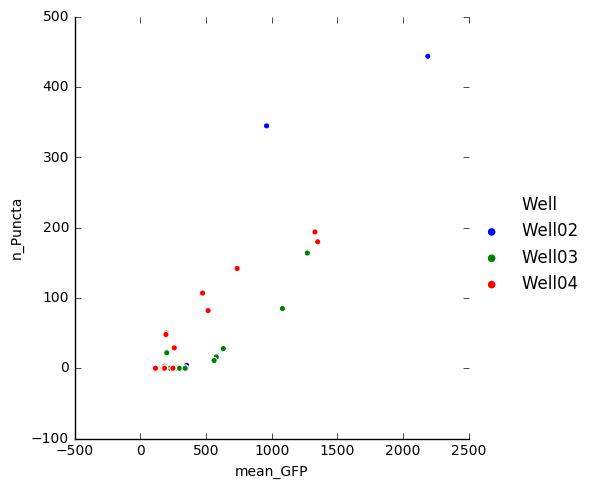

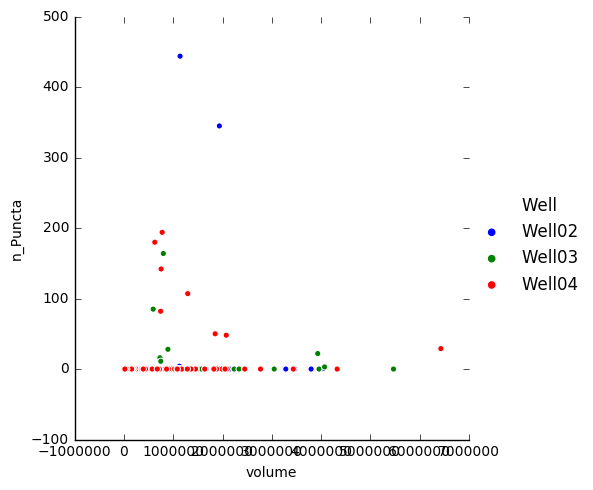

In [345]:
##Number of puncta scale with expression but not with nuclear volume
# sns.relplot(x="mean_GFP", y="n_Puncta", data=All_Hulls2);
# sns.relplot(x="mean_GFP", y="mean_Puncta_GFP", data=All_Hulls2);
# sns.relplot(x="volume", y="n_Puncta", data=All_Hulls2);
sns.relplot(x="mean_GFP", y="n_Puncta", hue='Well', data=df2);
sns.relplot(x="volume", y="n_Puncta", hue='Well', data=df2);
# plt.plot([2000000, 2000000], [0, 500], linewidth=2)

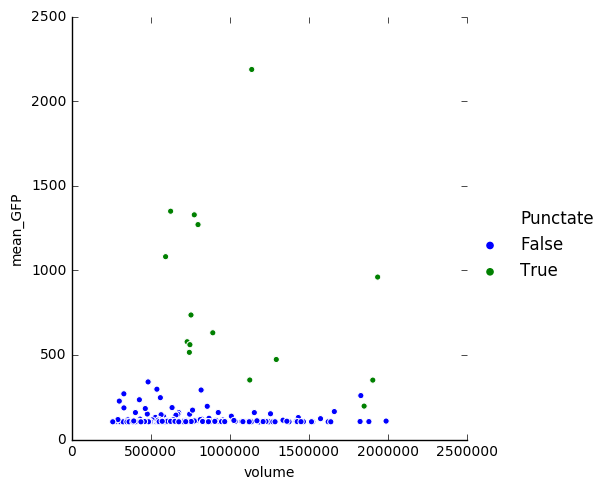

In [302]:
sns.relplot(x="volume", y="mean_GFP", hue='Punctate', data=Nuclei);

[B] Calculate nuclear properties for each puncta

In [351]:
df3=All_Spots.reset_index(drop=True)

In [388]:
##Save All_Hulls
df3.to_csv(newpath+"_All_Hulls_Annotated.csv")

In [355]:
#Merge df2 and df3 on three columns
df4=pd.merge(left=df2, right=df3, on=['Well','Stack','Hull'], suffixes=['','_Puncta'])
df4.columns

Index([u'Well', u'Stack', u'Hull', u'Center_x', u'Center_y', u'Center_z',
       u'volume', u'integrated_GFP', u'mean_GFP', u'std_GFP', u'median_GFP',
       u'threshold_GFP', u'n_Puncta', u'mean_Puncta_GFP', u'std_Puncta_GFP',
       u'mean_Puncta_volume', u'std_Puncta_volume', u'Punctate', u'Puncta',
       u'Center_x_Puncta', u'Center_y_Puncta', u'Center_z_Puncta',
       u'volume_Puncta', u'mean_GFP_Puncta', u'integrated_GFP_Puncta'],
      dtype='object')

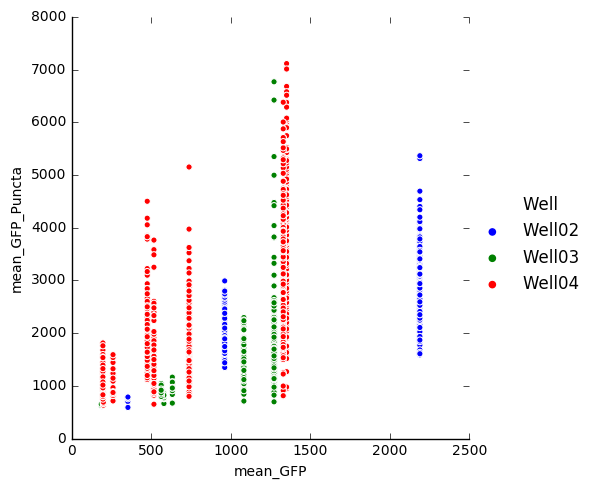

In [356]:
##All puncta
sns.relplot(x="mean_GFP", y="mean_GFP_Puncta", hue='Well', data=df4);

[C] Calculate the attrition rate Nuclei>Useable Nuclei>Of which transfected>Of which have puncta 

In [301]:
# print len(All_Hulls2)
# Full_z=All_Hulls2[All_Hulls2["Center_z"]==12] #Exclude partial
# print len(Full_z) 
# print len(Full_z[Full_z["volume"]>250000]) #Exclude small

# Nuclei=Full_z[Full_z["volume"].between(250000,2000000)] #Excluding small and big
# print len(Nuclei) 

# Transfected = Nuclei[Nuclei['mean_GFP']>150] #Exclude untransfected
# print len(Transfected)

# print len(Transfected[Transfected['Punctate']])

334
284
247
225
35
15


In [367]:
#Import Exp0104 platemap as pd.dataframe
Exp0104=pd.read_csv('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Exp0104_KDM5A_plate_map.csv')
Exp0104
#TODO add sequence files to platemap

,Well,Construct,Plasmid,Notes
0,Well01,flKDM5A,F00183,"puncta and some hollow puncta, odd anuclear ho..."
1,Well02,PHD2-IDR-PHD3,mini2,"some puncta, particularly in bright cells"
2,Well03,PHD2-IDR-PHD3[W1625A],mini1,Well03_2_is_garbage
3,Well04,PHD2-IDR,mini2,"Puncta, cell to cell heterogenetiy"
4,Well05,CTR,F00188,Plasmids mixed up. Do not analyse!!
5,Well06,CTR3,F00189,Plasmids mixed up. Do not analyse!! Seemed les...
6,Well07,CTR4,F00190,Plasmids mixed up. Do not analyse!! Mobile pun...
7,Well08,flKDM5A[H483A],F00184,NaN


In [374]:
##Annotate Wells with relevant Construct details
def lookup_construct(well):
    match = (Exp0104['Well'] == well)
    construct = Exp0104['Construct'][match]
    return construct.values[0]

df4['Construct'] = df4['Well'].apply(lookup_construct)

In [387]:
##Save df4
df4.to_csv(newpath+"_All_Spots.csv")

In [375]:
Full_z=df4[df4["Center_z"]==12] #Exclude partial
Nuclei=Full_z[Full_z["volume"].between(250000,2000000)] #Excluding small and big
Transfected = Nuclei[Nuclei['mean_GFP']>150] #Exclude untransfected
#13 nuclei are left
Transfected["Hull"].value_counts()

7     444
17    345
38    194
37    180
23    164
28    142
12    136
32    107
31     82
18     28
14     16
10     11
24      4
Name: Hull, dtype: int64

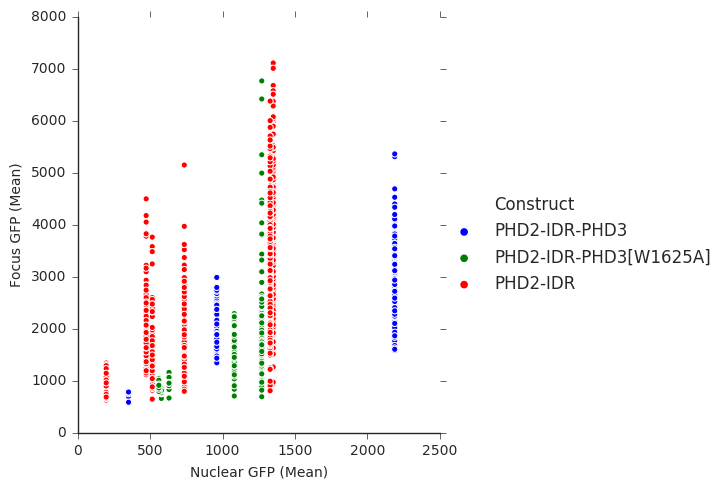

In [381]:
sns.set_style("ticks")
sns.relplot(x="mean_GFP", y="mean_GFP_Puncta", hue='Construct', data=Transfected);
plt.gca()
plt.xlabel('Nuclear GFP (Mean)')
plt.ylabel('Focus GFP (Mean)')

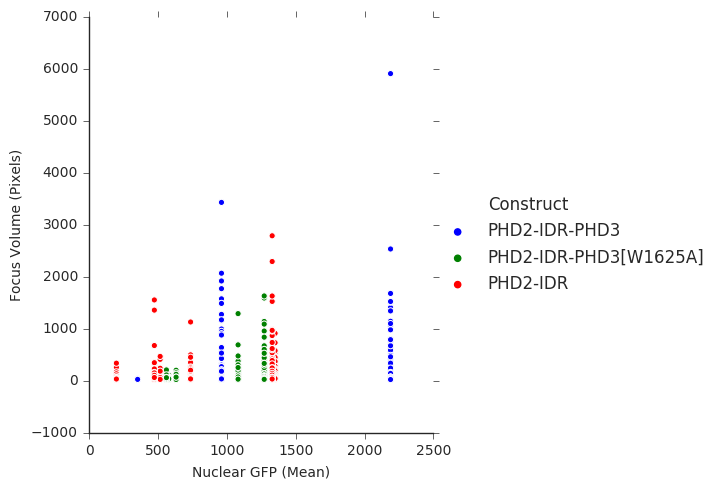

In [382]:
sns.set_style("ticks")
sns.relplot(x="mean_GFP", y="volume_Puncta", hue='Construct', data=Transfected);
plt.gca()
plt.xlabel('Nuclear GFP (Mean)')
plt.ylabel('Focus Volume (Pixels)')

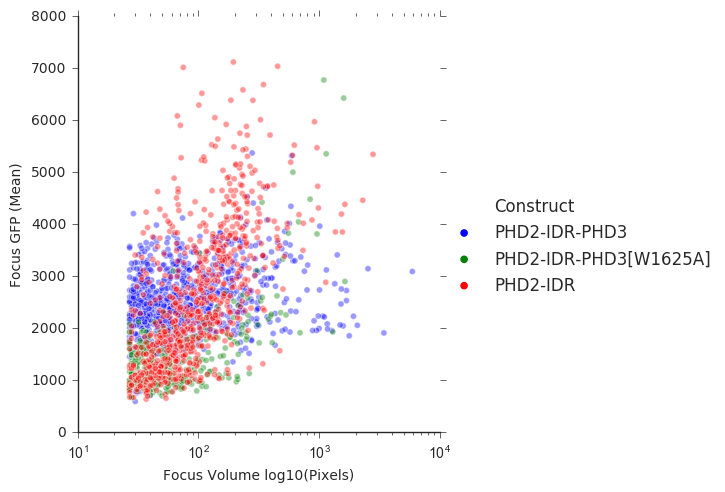

In [386]:
sns.set_style("ticks")
sns.relplot(x="volume_Puncta", y="mean_GFP_Puncta", hue='Construct', alpha=0.4, data=Transfected);
plt.gca()
plt.xlabel('Focus Volume log10(Pixels)')
plt.ylabel('Focus GFP (Mean)')
plt.xscale("log")

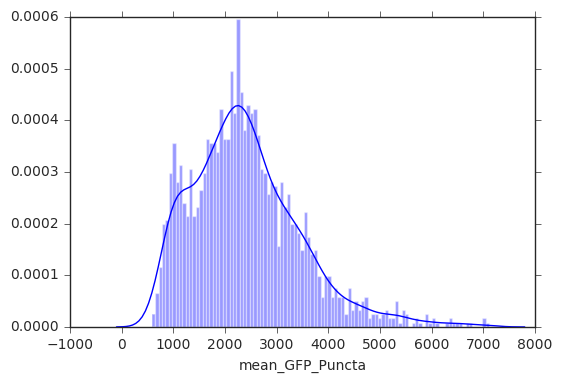

In [390]:
##Compare the distributions of Focus intensity
sns.distplot(Transfected['mean_GFP_Puncta'], bins=100)

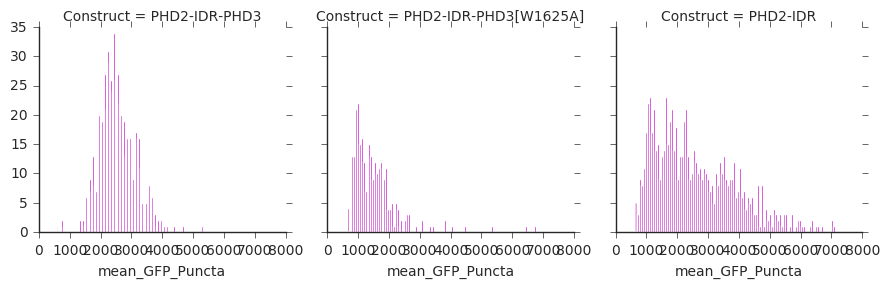

In [392]:
g = sns.FacetGrid(Transfected, col="Construct", col_order=["PHD2-IDR-PHD3", "PHD2-IDR-PHD3[W1625A]", "PHD2-IDR"])
g = g.map(plt.hist, "mean_GFP_Puncta", bins=100, color="m")

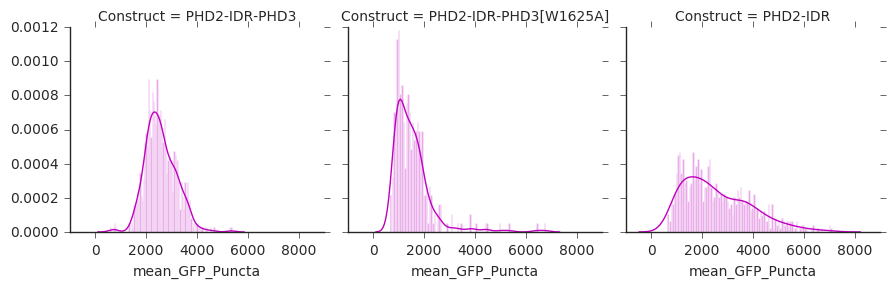

In [394]:
g = sns.FacetGrid(Transfected, col="Construct", col_order=["PHD2-IDR-PHD3", "PHD2-IDR-PHD3[W1625A]", "PHD2-IDR"])
g = g.map(sns.distplot, "mean_GFP_Puncta", bins=100, color="m")

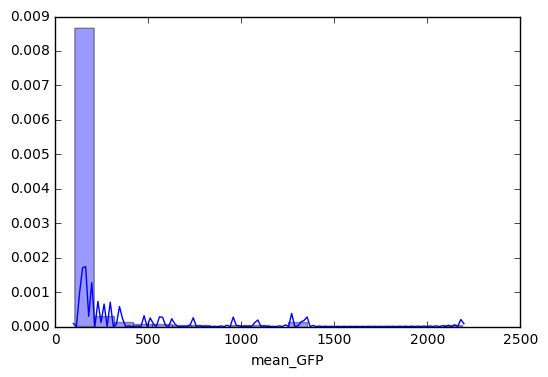

In [295]:
sns.distplot(Nuclei['mean_GFP'], bins=20)

[D] Calculate insignificance of observations

In [ ]:
All_Hulls

In [143]:
#Stack is a categorical
All_Hulls["Stack"]=All_Hulls.Stack.astype('category')
All_Spots["Stack"]=All_Spots.Stack.astype('category')

In [307]:
All_Hulls2[All_Hulls2['Punctate']].head()

Center_x  Center_y  Center_z   volume  integrated_GFP  \
Well   Stack Hull                                                          
Well02 1     26         586      1522        12  4049703    7.535963e+08   
       2     7          469       547        12  1138404    2.490973e+09   
             12         700       771        12  1905270    6.690441e+08   
             17         717      1155        12  1936059    1.859652e+09   
             24         608      1627        12  1125950    3.961101e+08   

                      mean_GFP     std_GFP  median_GFP  threshold_GFP  \
Well   Stack Hull                                                       
Well02 1     26     186.086803   85.784578       146.0     274.676868   
       2     7     2188.127201  761.258244      2312.0    3453.887366   
             12     351.154468  119.653290       308.0     487.479935   
             17     960.534527  855.992980       716.0    1999.989471   
             24     351.800784  124.450667       378.0     564.676001   

                   n_Puncta  mean_Puncta_GFP  std_Puncta_GFP  \
Well   Stack Hull                                              
Well02 1     26         1.0       616.294118             NaN   
       2     7        444.0      2917.083396      539.553376   
             12         1.0       703.275000             NaN   
             17       345.0      2163.854803      308.172023   
             24         4.0       728.196725       93.217281   

                   mean_Puncta_volume  std_Puncta_volume Punctate  
Well   Stack Hull                                                  
Well02 1     26             34.000000                NaN     True  
       2     7             174.966216         378.074427     True  
             12             40.000000                NaN     True  
             17            149.828986         315.013025     True  
             24             31.000000           1.414214     True

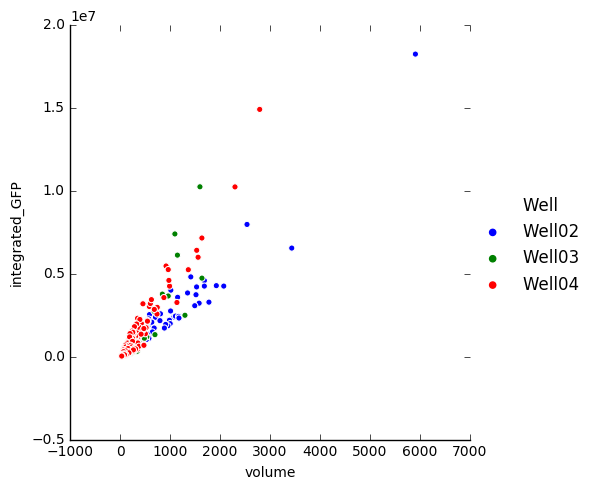

In [149]:
sns.relplot(x="volume", y="integrated_GFP", hue='Well', data=All_Spots);

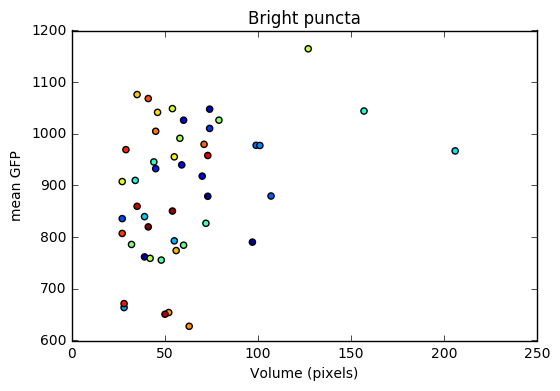

In [42]:
#Plot mean_GFP against size
plt.scatter(Puncta_Properties['volume'], Puncta_Properties['mean_GFP'], c=Puncta_Properties.index)
plt.xlabel("Volume (pixels)")
plt.ylabel("mean GFP")
plt.title("Bright puncta")

In [54]:
##Identify hollow puncta!!
#Fill and measure volume again. This didn't work
# from scipy.ndimage.morphology import binary_fill_holes

# full_blobs = binary_fill_holes(real_blobs)

**Examine the data with plots**

(array([ 16.,  15.,   9.,   1.,   3.,   1.,   0.,   1.,   0.,   1.]),
 array([  27. ,   44.9,   62.8,   80.7,   98.6,  116.5,  134.4,  152.3,
         170.2,  188.1,  206. ]),
 <a list of 10 Patch objects>)

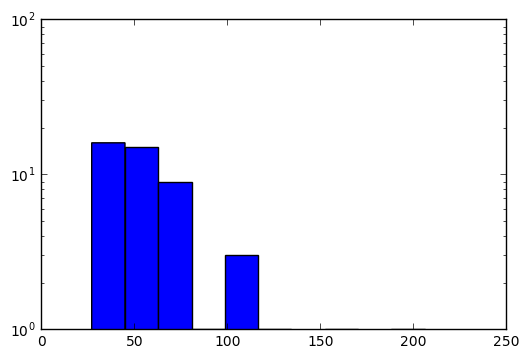

In [47]:
plt.hist(Puncta_Properties['volume'], log=True)

(array([  7.,  12.,  27.,  38.,  34.,  43.,  47.,  38.,  47.,  36.,  31.,
         43.,  27.,  32.,  37.,  38.,  45.,  44.,  46.,  41.,  51.,  44.,
         44.,  60.,  50.,  72.,  55.,  46.,  52.,  50.,  51.,  45.,  37.,
         36.,  31.,  34.,  33.,  19.,  34.,  28.,  31.,  24.,  24.,  22.,
         18.,  27.,  21.,  17.,  18.,  12.,   7.,  12.,  12.,   7.,   9.,
          7.,   7.,   3.,   9.,   4.,   6.,   4.,   6.,   7.,   2.,   3.,
          3.,   2.,   3.,   4.,   2.,   2.,   6.,   1.,   4.,   3.,   0.,
          1.,   2.,   1.,   0.,   3.,   1.,   2.,   1.,   0.,   0.,   1.,
          2.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   2.,
          1.]),
 array([  589.86666667,   655.1234359 ,   720.38020513,   785.63697436,
          850.89374359,   916.15051282,   981.40728205,  1046.66405128,
         1111.92082051,  1177.17758974,  1242.43435897,  1307.69112821,
         1372.94789744,  1438.20466667,  1503.4614359 ,  1568.71820513,
         1633.97497436,  1699.

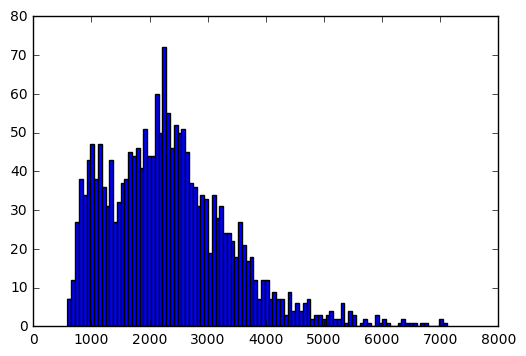

In [151]:
plt.hist(All_Spots['mean_GFP'], bins=100)

(array([  6.,  10.,   8.,   4.,   5.,   4.,   4.,   0.,   3.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([  18586. ,   27616.2,   36646.4,   45676.6,   54706.8,   63737. ,
          72767.2,   81797.4,   90827.6,   99857.8,  108888. ,  117918.2,
         126948.4,  135978.6,  145008.8,  154039. ,  163069.2,  172099.4,
         181129.6,  190159.8,  199190. ]),
 <a list of 20 Patch objects>)

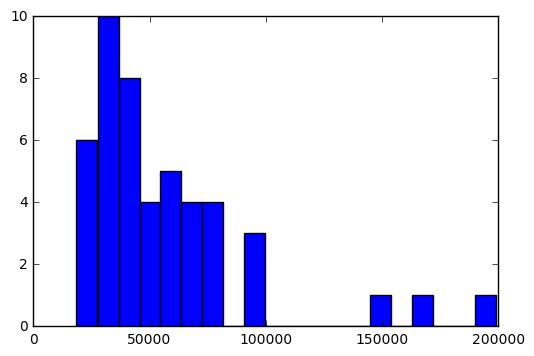

In [48]:
plt.hist(Puncta_Properties['integrated_GFP'], bins=20)

In [50]:
Hull_Properties.loc[[14,16,18],:]

,Center_x,Center_y,Center_z,volume,integrated_GFP,mean_GFP,std_GFP,median_GFP,threshold_GFP
14,1044,1023,12,729341,421648818.0,578.123015,167.156076,602.0,852.734114
16,965,1377,12,4072787,748717513.0,183.834193,130.900396,126.0,322.350594
18,567,1530,12,891818,562785220.0,631.053892,217.417173,677.0,1003.125759


In [124]:
##Calculate puncta metrics with respect to 'Hull'
a = np.array(Puncta_Properties["volume"].astype(float))
b = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"volume"].astype(float))
c = np.divide(np.array(Puncta_Properties["volume"].astype(float)),np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"volume"].astype(float)))

#Check calculation
# temp_d = np.transpose([a, b, c])
# temp_h = ["Puncta_Volume", "Hull_Volume", "Fraction"]
# temp=pd.DataFrame(temp_d, columns=temp_h)
# temp

In [52]:
Puncta_Properties["hull_volume"] = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"volume"].astype(float))
Puncta_Properties["fraction_hull_volume"] = PunctaByHull("volume","volume")

Puncta_Properties["hull_mean_GFP"] = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"mean_GFP"].astype(float))
Puncta_Properties["Relative_GFP"] = PunctaByHull("mean_GFP","mean_GFP")

Puncta_Properties["hull_integrated_GFP"] = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"integrated_GFP"].astype(float))
Puncta_Properties["fraction_GFP_intensity"] = PunctaByHull("integrated_GFP","integrated_GFP")

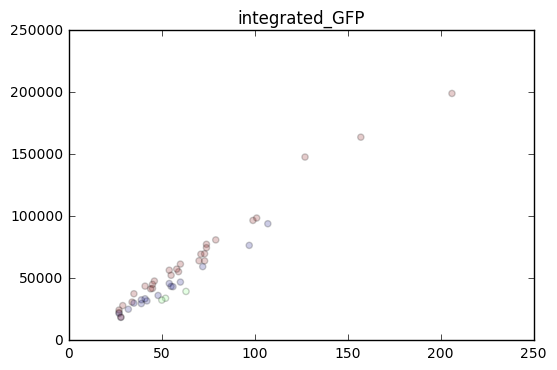

In [53]:
##Compare puncta size between cells
fig, ax = plt.subplots()
plt.scatter('volume', 'integrated_GFP', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('integrated_GFP')
#ax.set_xlim((0,500))
#plt.legend()

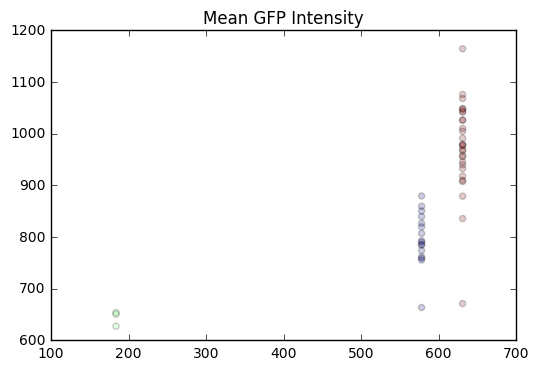

In [54]:
##Compare puncta size between cells
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'mean_GFP', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Mean GFP Intensity')
#ax.set_xlim((0,500))
#plt.legend()

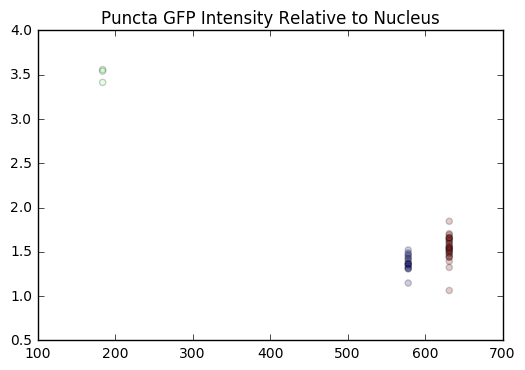

In [55]:
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'Relative_GFP', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Puncta GFP Intensity Relative to Nucleus')

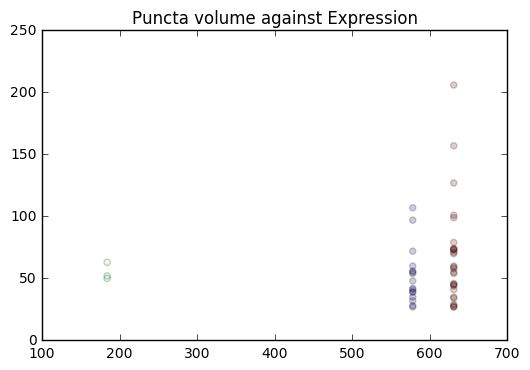

In [56]:
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'volume', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Puncta volume against Expression')

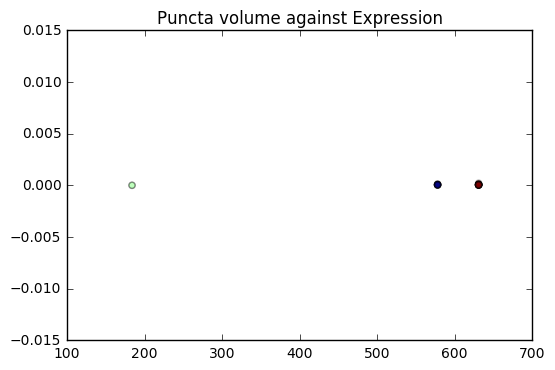

In [57]:
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'fraction_hull_volume', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Puncta volume against Expression')

In [396]:
Mask5=np.load('C:\Users\David Brown\Documents\Huang Lab\Exp0104_KDM5A_PHD2-fragments\Output\Well02_HeLa_PHD2-IDR-PHD3_1_Mask5.npy')

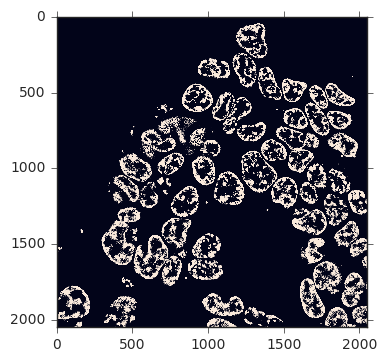

In [398]:
plt.imshow(Mask5[4])

In [402]:
Mask5.shape

(24L, 2048L, 2048L)

In [405]:
# create data
d = np.ndarray(shape=(10,20), dtype=np.float32) # also supports 64bit but ImageJ does not
d[()] = np.arange(200).reshape(10, 20)

d.shape

# save 32bit float (== single) tiff
#imsave('test.tif', d) #, description="hohoho")

(10L, 20L)

In [406]:
plt.imsave('C:\Users\David Brown\Documents\Huang Lab\Exp0104_KDM5A_PHD2-fragments\Output\Well02_HeLa_PHD2-IDR-PHD3_1_Mask5_z1.tiff', np.array(Mask5[0]), cmap='gray')